# Replay buffer for MNIST classification

In [1]:
import os
import jax
import optax
import dynamax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from flax.training.train_state import TrainState

In [2]:
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.utils import datasets

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format = "retina"

# Classification MNIST

In [6]:
train, test = datasets.load_classification_mnist()
X, y_ohe = train
X_test, y_ohe_test = test

y = y_ohe.argmax(axis=1)
y_test = y_ohe_test.argmax(axis=1)

In [7]:
num_train = 1_000
train, test = datasets.load_mnist()

X, y = train
X_test, y_test = test

X = jnp.array(X)[:num_train].reshape(-1, 28 ** 2)
y = jnp.array(y)[:num_train]
y_ohe = jax.nn.one_hot(y, 10)

X_test = jnp.array(X_test).reshape(-1, 28 ** 2)
y_test = jnp.array(y_test)
y_ohe_test = jax.nn.one_hot(y_test, 10)

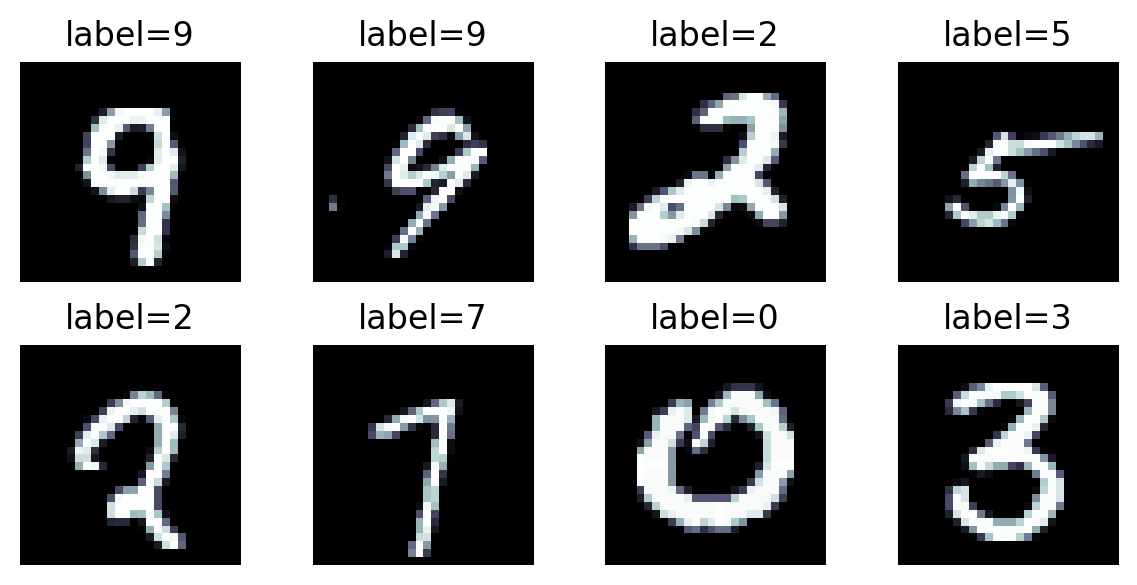

In [8]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X), size=n_test)

fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X[ix]
    label = y[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{label=:0.0f}")
plt.tight_layout()

# Training

## Setup

In [9]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [10]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## Vanilla SGD

In [11]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    
    nll = -y * jnp.log(probs)
    return nll.sum(axis=-1).mean()


@partial(jax.jit, static_argnames=("applyfn",))
def metric(params, X, y, applyfn):
    yhat = applyfn(params, X).squeeze().argmax(axis=-1)
    acc = (y == yhat).mean()
    return acc

In [13]:
%%time

num_epochs = 1_000
batch_size = 1000

model = MLP(10, activation=nn.elu)
batch_init = jnp.ones((10, 28 ** 2))
params_init = model.init(key_init, batch_init)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(5e-5),
)


state, losses = sgd.train_full(
    key_init, num_epochs, batch_size, state, X, y_ohe, lossfn,
    X_test, y_ohe_test
)
losses = jax.block_until_ready(losses)

CPU times: user 5.8 s, sys: 17 ms, total: 5.82 s
Wall time: 2.85 s


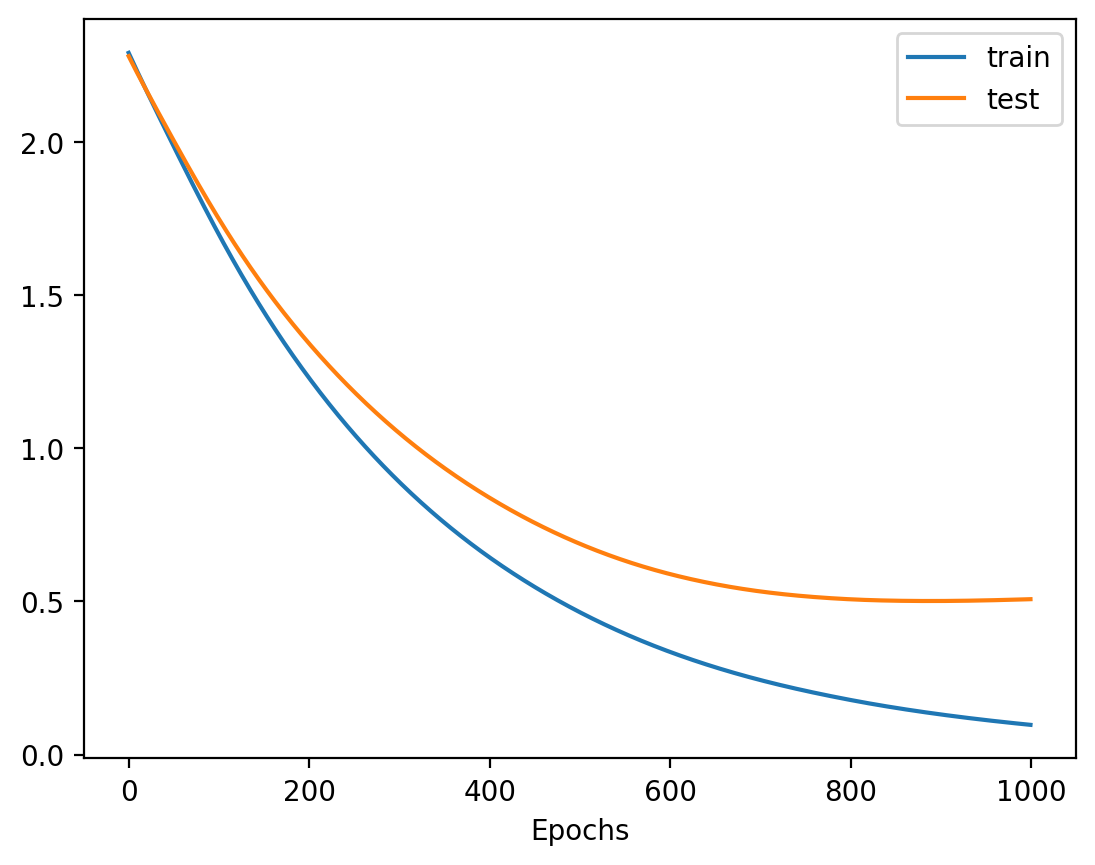

In [14]:
plt.plot(losses["train"], label="train")
plt.plot(losses["test"], label="test")
plt.legend()
plt.xlabel("Epochs");

# Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0,]
[x0, x1]
[x0, x1, x2]
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
...
```

In [52]:
learning_rate = 5e-5

In [53]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    
    nll = -y * jnp.log(probs)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss

In [54]:
model = MLP(10, activation=nn.elu)
batch_init = jnp.ones((10, 28 ** 2))
params_init = model.init(key_init, batch_init)

In [59]:
%%time
dim_features = 28 ** 2
dim_output = 10

buffer_size = 100
n_inner = 5


state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=dim_output,
)


rebayes = rsgd.FifoSGD(lossfn_fifo, n_inner=n_inner)

def rmae_test(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    
    yhat_test = model.apply(bel.params, X_test).squeeze()
    acc_test = (yhat_test.argmax(axis=1) == y_test).mean()
    
    res = {
        "test": acc_test
    }
    return res


test = {"X_test": X_test, "y_test": y_test}
state, losses = rebayes.scan(X, y_ohe, bel=state_init, callback=rmae_test, **test)
acc = rmae_test(state, X_test=X_test, y_test=y_test)["test"]
acc = jax.block_until_ready(acc)

CPU times: user 4.72 s, sys: 62.5 ms, total: 4.79 s
Wall time: 3.11 s


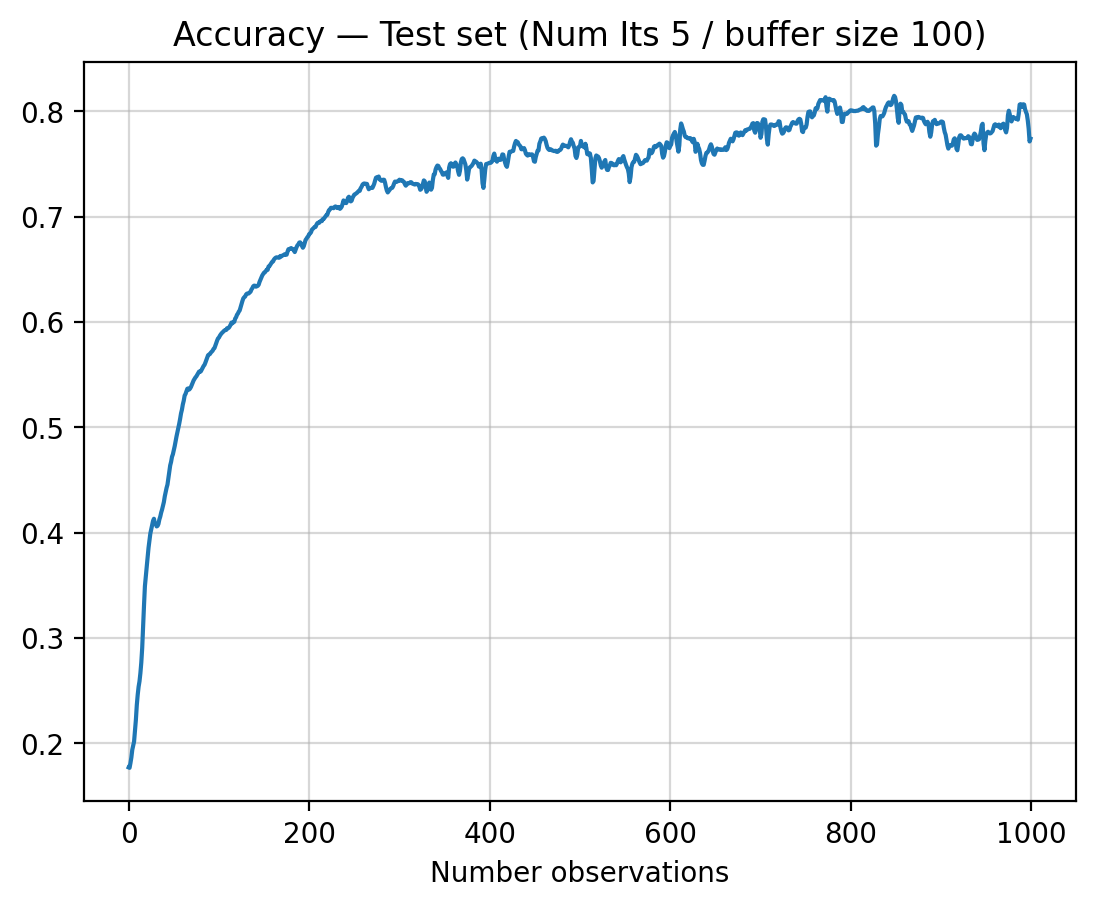

In [60]:
plt.plot(losses["test"])
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

In [61]:
%%time
n_inner = 5
buffer_size = 100

@partial(jax.pmap, in_axes=0)
@partial(jax.vmap, in_axes=1)
def init_and_train(key):
    params_init = model.init(key, batch_init)

    rebayes = rsgd.FifoSGD(lossfn_fifo, n_inner=n_inner)
    
    params_init = model.init(key, batch_init)
    state_init = rsgd.FifoTrainState.create(
        apply_fn=model.apply,
        params=params_init,
        tx=optax.adam(learning_rate),
        buffer_size=buffer_size,
        dim_features=dim_features,
        dim_output=dim_output,
    )
    
    
    state, losses = rebayes.scan(X, y_ohe, bel=state_init, callback=rmae_test, progress_bar=False, **test)
    return state, losses
    

n_samples = 8 * 5
keys = jax.random.split(key, n_samples).reshape(8, 2, -1)
states, losses = init_and_train(keys)
losses = jax.block_until_ready(losses)

CPU times: user 19.7 s, sys: 656 ms, total: 20.4 s
Wall time: 13 s


In [62]:
losses_test = losses["test"].reshape(n_samples, -1)

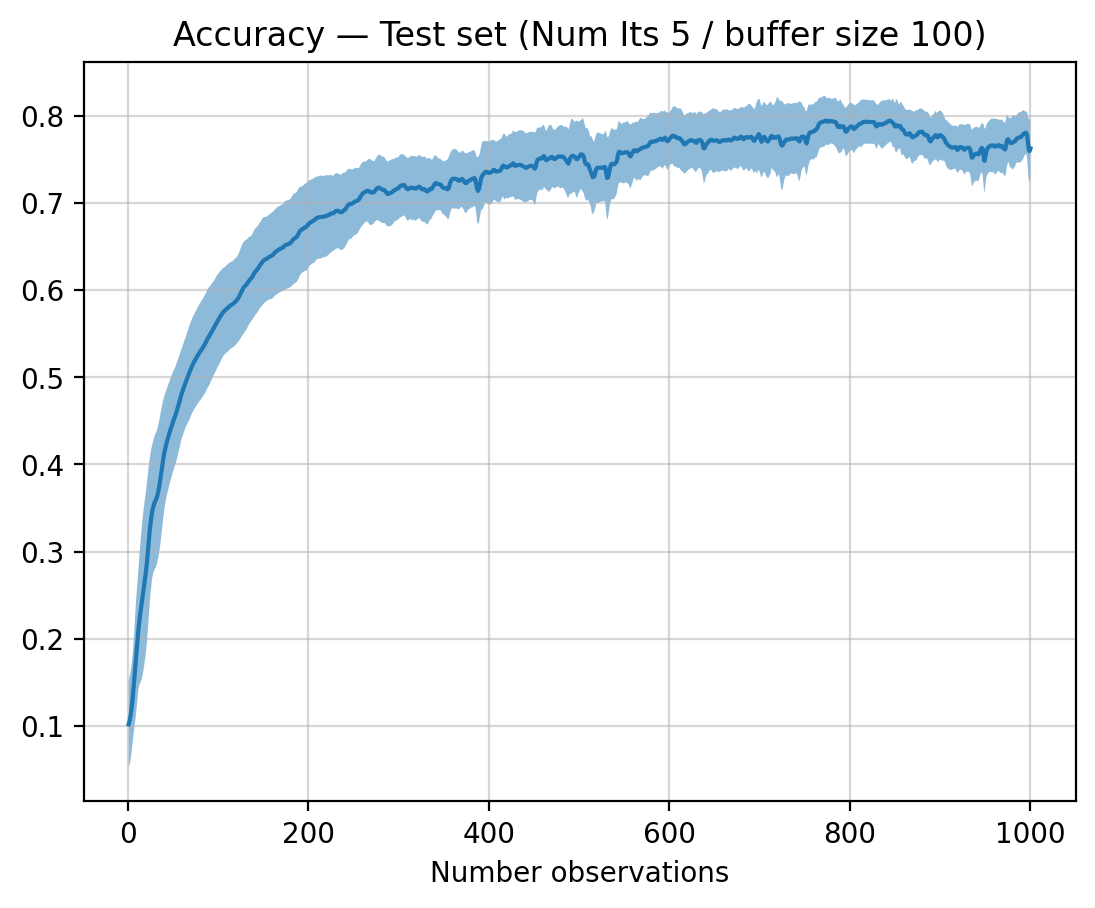

In [63]:
xrange = jnp.ones_like(y).cumsum()
losses_test = losses["test"].reshape(n_samples, -1)
mean_loss = losses_test.mean(axis=0)
std_loss = losses_test.std(axis=0)
plt.plot(xrange, mean_loss)
plt.fill_between(xrange, mean_loss - 2 * std_loss, mean_loss + 2 * std_loss, alpha=0.5)
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

In [64]:
losses_test[:, -1].mean()

Array(0.76232755, dtype=float32)

### Multiple buffer sizes

In [68]:
%%time
buffer_size_list = [1, 5, 10, 20, 50, 100, 200, 300]
n_buffers = len(buffer_size_list)

n_inner = 5
test_losses = {}


state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=dim_output,
)


for buffer_size in (pbar := tqdm(buffer_size_list)):
    
    state_init_test = state_init.replace(buffer_size=buffer_size)
    
    rebayes = rsgd.FifoSGD(lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(X, y_ohe, bel=state_init_test, callback=rmae_test, progress_bar=False, **test)
    test_losses[buffer_size] = losses["test"]
    acc = losses["test"][-1]
    pbar.set_description(f"acc-{buffer_size:03}={acc:0.4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 43.5 s, sys: 667 ms, total: 44.2 s
Wall time: 27.6 s


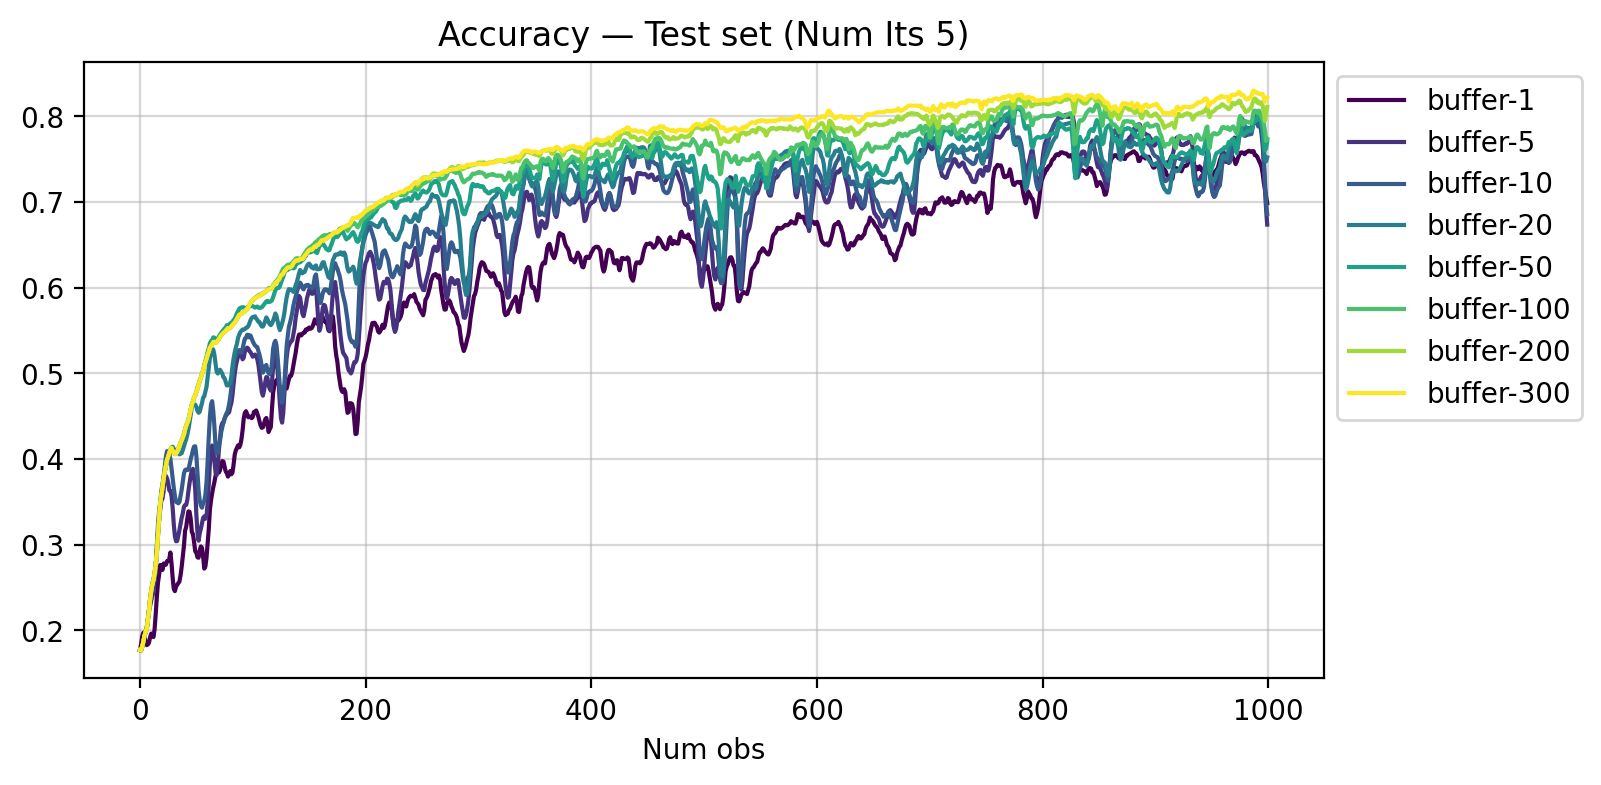

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    loss_test = test_losses[buffer_size]
    plt.plot(loss_test, c=c, label=f"buffer-{buffer_size}")
    
plt.xlabel("Num obs")
plt.title(f"Accuracy — Test set (Num Its {n_inner})")
# plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)

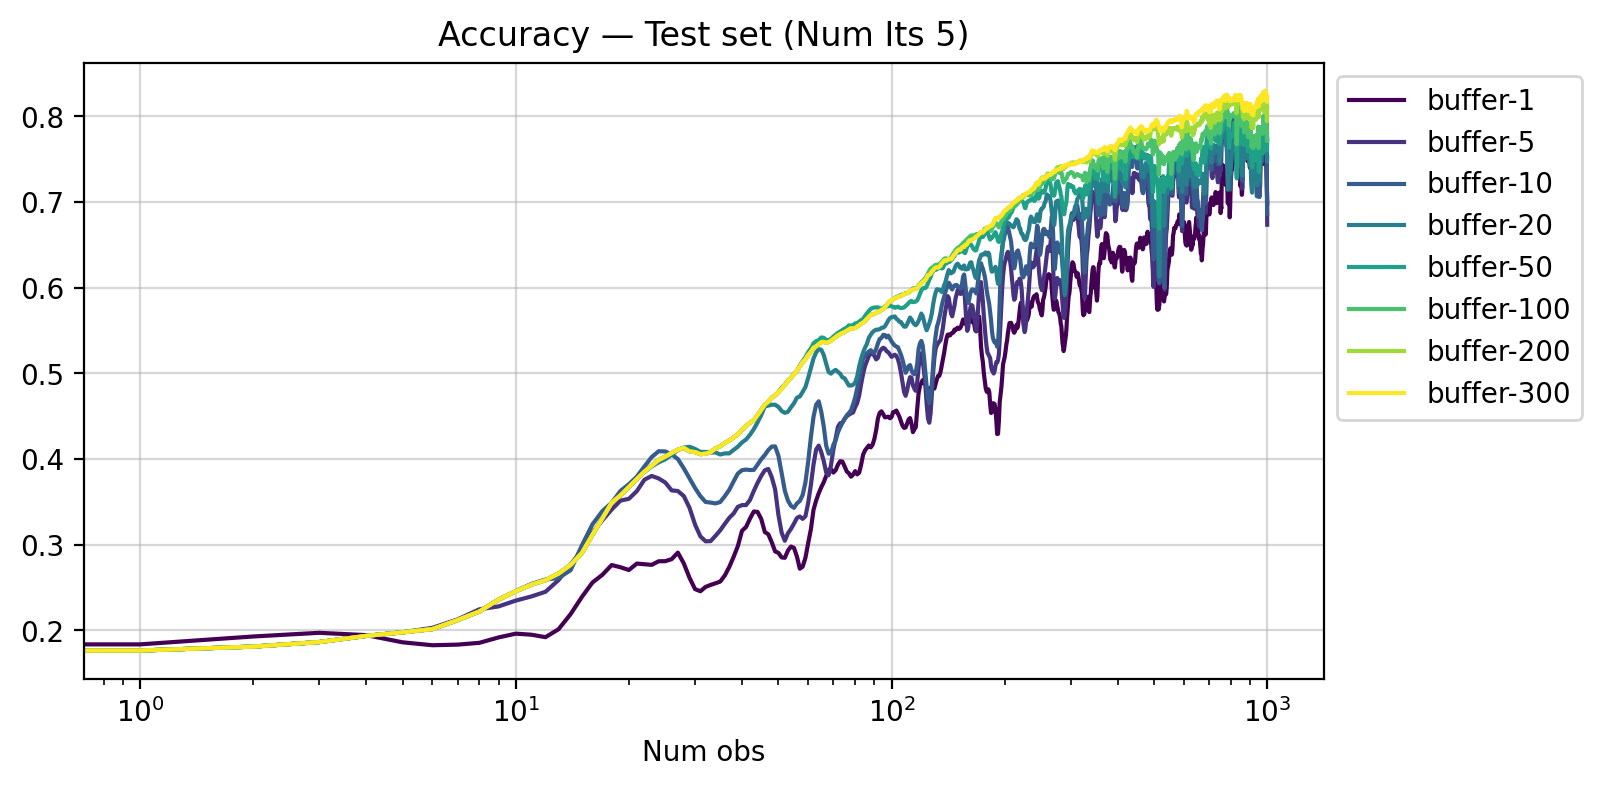

In [70]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    loss_test = test_losses[buffer_size]
    plt.plot(loss_test, c=c, label=f"buffer-{buffer_size}")
    
plt.xlabel("Num obs")
plt.title(f"Accuracy — Test set (Num Its {n_inner})")
# plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)
plt.xscale("log")